In [147]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

In [148]:
!kaggle competitions download -c tabular-playground-series-sep-2022

2022-09-09 13:55:07,013 WARNING Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000028732B0BEB0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')': /api/v1/competitions/data/download-all/tabular-playground-series-sep-2022
2022-09-09 13:55:07,013 WARNING Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000028732B0BD30>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')': /api/v1/competitions/data/download-all/tabular-playground-series-sep-2022
2022-09-09 13:55:07,013 WARNING Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000028732AFAEE0>: Failed to establish a ne

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import zipfile
import seaborn as sns

In [2]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
from matplotlib import pyplot as plt

In [4]:
train = pd.read_csv("./data/train.csv", index_col="row_id")
test = pd.read_csv("./data/test.csv", index_col="row_id")
submission = pd.read_csv("./data/sample_submission.csv")

In [5]:
train.head(5)

,date,country,store,product,num_sold
row_id,,,,,
0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [6]:
target = "num_sold"

In [7]:
test.head(5)

,date,country,store,product
row_id,,,,
70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


In [8]:
train["date"] = pd.to_datetime(train["date"])
test["date"] = pd.to_datetime(test["date"])

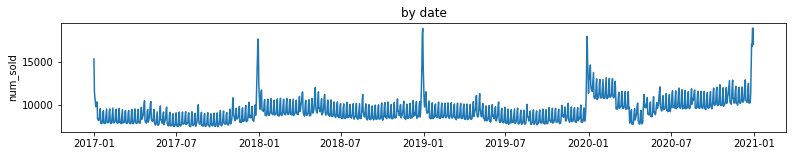

In [9]:
plt.figure(figsize=(13, 2))

train_date = train.groupby("date")[target].sum().reset_index()

plt.plot(train_date["date"], train_date[target])
plt.title("by date")
plt.ylabel(target)
plt.show()

In [10]:
train_date.head()

,date,num_sold
0,2017-01-01,15352
1,2017-01-02,11578
2,2017-01-03,10884
3,2017-01-04,10445
4,2017-01-05,9795


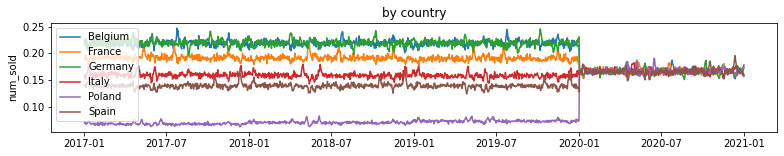

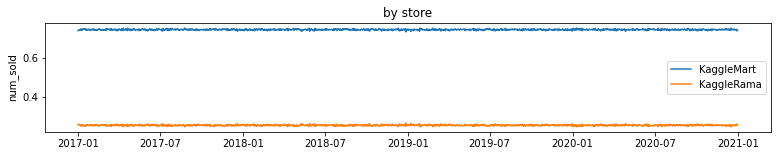

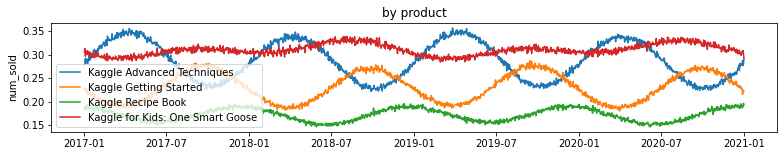

[0.7425193179463185, 0.25748068205368146]


In [11]:
columns = ["country", "store", "product"]
target = "num_sold"
ratios = []

ratio = True

for column in columns:
    plt.figure(figsize=(13, 2))
    
    for item in train[column].unique():
        data = train[train[column] == item]
        
        train_grouped = data.groupby(["date"])[target].sum().reset_index()
        
        if ratio:
            train_grouped[target] /= train_date[target]
            
        if column == "store":
            ratios.append(train_grouped[target].mean())
        
        plt.plot(train_grouped["date"], train_grouped[target], label=item)
        plt.title("by " + column)
        plt.ylabel(target)
    
    plt.legend()
    plt.show()
    
print(ratios)

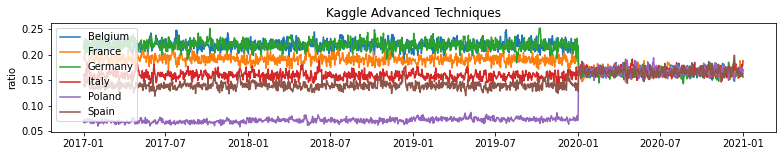

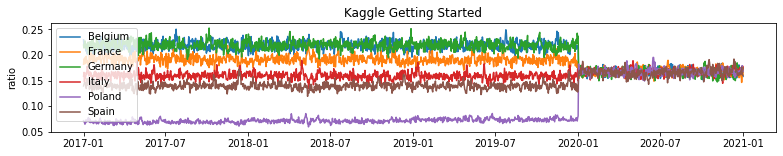

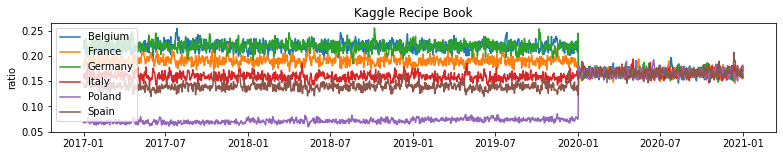

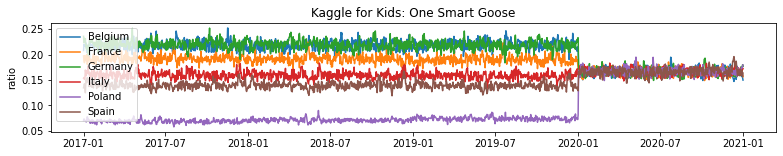

In [12]:
def per_element(base, element):
    elements = train[element].unique()
    
    for item in elements:
        plt.figure(figsize=(13, 2))

        data = train[train[element] == item]
        data_grouped = data.groupby(["date", base])[target].sum().reset_index().pivot(index="date",
                                                                            columns=base,
                                                                            values=target)

        data_grouped /= data_grouped.sum(axis=1).values.reshape((-1, 1))

        for column in data_grouped.columns:
            plt.plot(data_grouped.index, data_grouped[column], label=column)

        plt.title(item)
        plt.legend()
        plt.ylabel("ratio")

        plt.show()
        
per_element("country", "product")

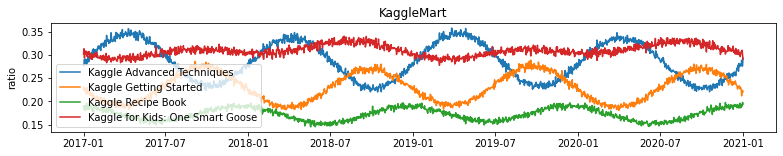

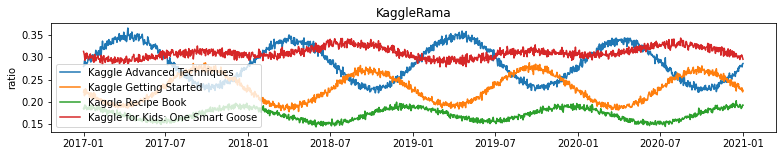

In [13]:
per_element("product", "store")

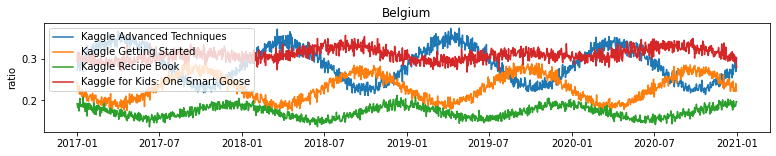

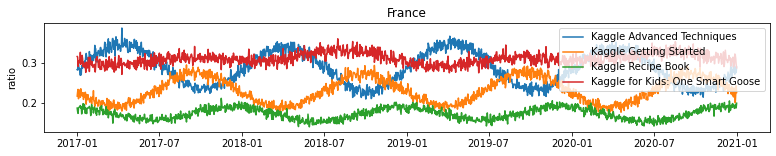

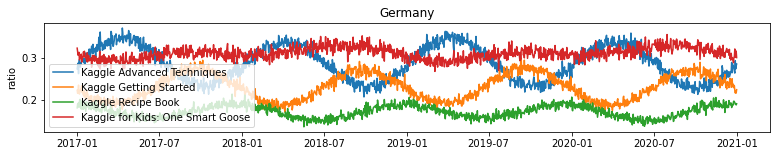

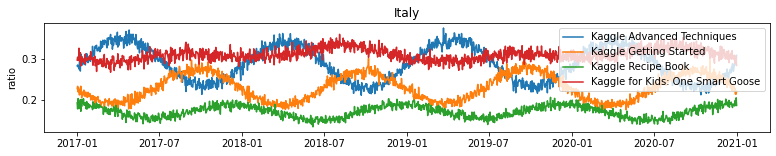

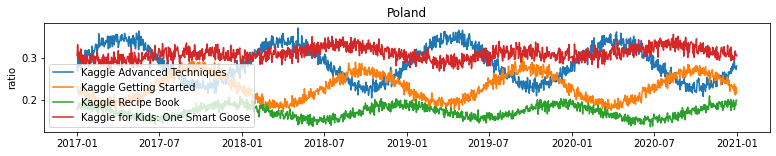

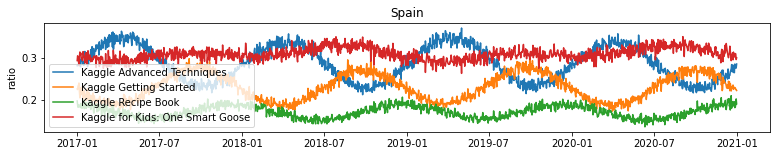

In [14]:
per_element("product", "country")

### модель для предсказания общего num_sold по дням

In [140]:
train_gp = train.groupby("date")[target].sum().reset_index()[["date", target]]
train_gp.head()

,date,num_sold
0,2017-01-01,15352
1,2017-01-02,11578
2,2017-01-03,10884
3,2017-01-04,10445
4,2017-01-05,9795


In [141]:
test_gp = test.groupby("date").sum().reset_index()[["date"]]
test_gp[target] = -1.0
test_gp.head()

,date,num_sold
0,2021-01-01,-1.0
1,2021-01-02,-1.0
2,2021-01-03,-1.0
3,2021-01-04,-1.0
4,2021-01-05,-1.0


In [142]:
concat = train_gp.append(test_gp)
concat.head(5)

,date,num_sold
0,2017-01-01,15352.0
1,2017-01-02,11578.0
2,2017-01-03,10884.0
3,2017-01-04,10445.0
4,2017-01-05,9795.0


In [152]:
year = concat["date"].dt.year

day = pd.get_dummies(concat["date"].dt.dayofweek, prefix="dw").iloc[:, :-1]
day_month = pd.get_dummies(concat["date"].dt.day, prefix="d").iloc[:, :-1]
month = pd.get_dummies(concat["date"].dt.month, prefix="mn").iloc[:, :-1]

In [153]:
all_data = concat.copy()
all_data["year"] = year
all_data = pd.concat([all_data, day_month], axis=1)
all_data = pd.concat([all_data, day], axis=1)
all_data = pd.concat([all_data, month], axis=1)

all_data.head()

,date,num_sold,year,d_1,d_2,d_3,d_4,d_5,d_6,d_7,...,mn_2,mn_3,mn_4,mn_5,mn_6,mn_7,mn_8,mn_9,mn_10,mn_11
0,2017-01-01,15352.0,2017,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2017-01-02,11578.0,2017,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2017-01-03,10884.0,2017,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2017-01-04,10445.0,2017,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2017-01-05,9795.0,2017,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [154]:
train_data = all_data[all_data[target] != -1.0]
test_data  = all_data[all_data[target] == -1.0]

X = train_data[train_data.columns[2:]]
y = train_data[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75)

In [155]:
# reg = LinearRegression()
# reg = RandomForestRegressor(max_depth=max_param)
reg = Ridge()

reg.fit(X_train, y_train)

predict = reg.predict(X_val)
1 - np.sum((predict - y_val)**2) / np.sum((y_val.mean() - y_val)**2)

0.527494876996082

In [156]:
target

'num_sold'

In [157]:
reg.fit(X, y)

X_test = test_data[test_data.columns[2:]]
predict = pd.DataFrame({target: reg.predict(X_test)})

In [158]:
predict.head()

,num_sold
0,11463.530025
1,12296.850070
2,12707.806107
3,11036.713654
4,11093.277543


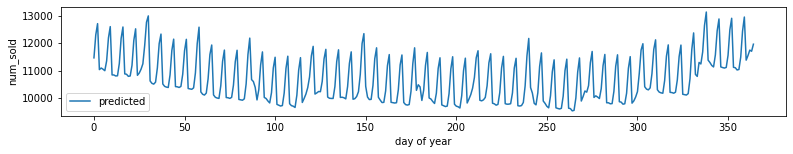

In [159]:
def plot(data, label):
    plt.figure(figsize=(13, 2))

    plt.plot(data, label=label)
    plt.xlabel("day of year")
    plt.ylabel(target)

    plt.title("")
    plt.legend()
    plt.show()
    
plot(predict, "predicted")

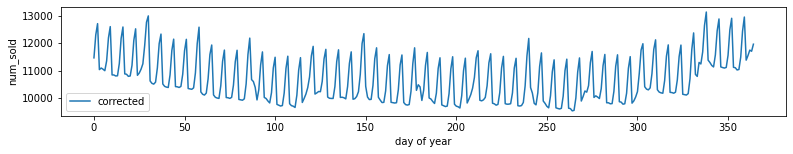

In [160]:
k = 0 # angle
b = 0 # offset

corrected = [value + b + index * k for index, value in enumerate(predict[target].values)]

plot(corrected, "corrected")

In [161]:
# test_data[target] = predict[target]
test_data[target] = corrected

test_data.head(5)

<ipython-input-161-47c154f4e8d1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[target] = corrected


,date,num_sold,year,d_1,d_2,d_3,d_4,d_5,d_6,d_7,...,mn_2,mn_3,mn_4,mn_5,mn_6,mn_7,mn_8,mn_9,mn_10,mn_11
0,2021-01-01,11463.530025,2021,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-02,12296.850070,2021,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-03,12707.806107,2021,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-04,11036.713654,2021,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-01-05,11093.277543,2021,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


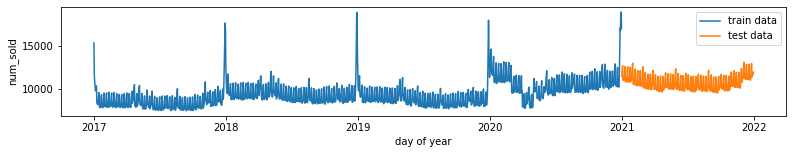

In [162]:
plt.figure(figsize=(13, 2))

plt.plot(train_data["date"], train_data[target], label="train data")
plt.plot(test_data["date"], test_data[target],
         label="test data")

plt.xlabel("day of year")
plt.ylabel(target)

plt.title("")
plt.legend()
plt.show()

In [163]:
train_data.head(5)

,date,num_sold,year,d_1,d_2,d_3,d_4,d_5,d_6,d_7,...,mn_2,mn_3,mn_4,mn_5,mn_6,mn_7,mn_8,mn_9,mn_10,mn_11
0,2017-01-01,15352.0,2017,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2017-01-02,11578.0,2017,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2017-01-03,10884.0,2017,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2017-01-04,10445.0,2017,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2017-01-05,9795.0,2017,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [164]:
test_data.head(5)

,date,num_sold,year,d_1,d_2,d_3,d_4,d_5,d_6,d_7,...,mn_2,mn_3,mn_4,mn_5,mn_6,mn_7,mn_8,mn_9,mn_10,mn_11
0,2021-01-01,11463.530025,2021,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-02,12296.850070,2021,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-03,12707.806107,2021,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-04,11036.713654,2021,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-01-05,11093.277543,2021,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### модель среднего для отношений по продуктам

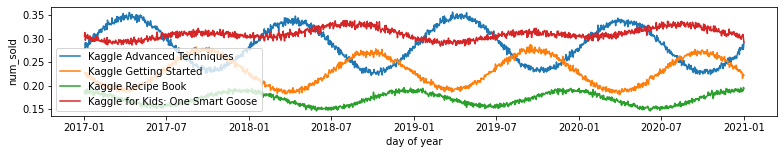

In [101]:
df_train = train.groupby(["date", 
                    "product"])[target].sum().reset_index().pivot(index="date",
                                                                  columns="product",
                                                                  values=target).reset_index()

df_train["total"] = df_train.iloc[:, 1:].sum(axis=1)

plt.figure(figsize=(13, 2))
for product in df_train.columns[1:-1]:
    df_train[product] /= df_train["total"]
    plt.plot(df_train["date"], df_train[product], label=product)
plt.legend()
plt.xlabel("day of year")
plt.ylabel(target)
plt.show()

In [102]:
day = pd.DataFrame({"day": df_train["date"].dt.dayofyear})

try:
    del df_train["total"]
except:
    pass

df_train["day"] = day
df_train.sample(5)

product,date,Kaggle Advanced Techniques,Kaggle Getting Started,Kaggle Recipe Book,Kaggle for Kids: One Smart Goose,day
362,2017-12-29,0.276212,0.227938,0.190814,0.305036,363
1283,2020-07-07,0.293043,0.230864,0.151857,0.324236,189
185,2017-07-05,0.303585,0.235410,0.158074,0.302931,186
417,2018-02-22,0.321396,0.198260,0.179394,0.300949,53
727,2018-12-29,0.282866,0.226641,0.191882,0.298611,363


In [103]:
df_test = pd.DataFrame(test_data["date"].copy())
day = pd.DataFrame({"day": df_test["date"].dt.dayofyear})
df_test["day"] = day

for product in df_train.columns[1: -1]:
    temp = pd.DataFrame(df_train[[product, "day"]].copy())
    mean = temp.groupby("day")[product].mean().values
    mapping = {key + 1: value for key, value in enumerate(mean)}
    df_test[product] = df_test["day"].map(mapping)

del df_test["day"]
df_test["day"] = day    
df_test.sample(5)

,date,Kaggle Advanced Techniques,Kaggle Getting Started,Kaggle Recipe Book,Kaggle for Kids: One Smart Goose,day
42,2021-02-12,0.322436,0.201570,0.180714,0.295281,43
27,2021-01-28,0.308210,0.206679,0.184052,0.301059,28
270,2021-09-28,0.229725,0.273042,0.174750,0.322483,271
173,2021-06-23,0.301115,0.227687,0.155989,0.315208,174
213,2021-08-02,0.266401,0.252481,0.159962,0.321156,214


In [104]:
df_data = df_train.copy()
df_data = df_data.append(df_test)

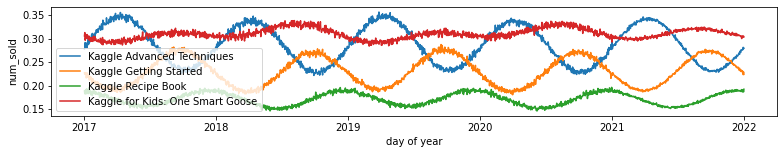

In [105]:
plt.figure(figsize=(13, 2))
for product in df_data.columns[1: -1]:
    plt.plot(df_data["date"], df_data[product], label=product)
plt.legend()
plt.xlabel("day of year")
plt.ylabel(target)
plt.show()

### расчёт цели

In [106]:
results = df_test[["date",
                   "Kaggle Advanced Techniques",
                   "Kaggle Getting Started",
                   "Kaggle Recipe Book",
                   "Kaggle for Kids: One Smart Goose"]].copy()

for product in results.columns[1:]:
    results[product] *= test_data[target]
    
results = results.set_index("date")
results.head(5)

,Kaggle Advanced Techniques,Kaggle Getting Started,Kaggle Recipe Book,Kaggle for Kids: One Smart Goose
date,,,,
2021-01-01,3164.952099,2589.777466,2167.555035,3458.233190
2021-01-02,3468.942103,2746.715443,2304.489688,3764.359059
2021-01-03,3602.165924,2883.644943,2365.480861,3848.870380
2021-01-04,3133.729838,2460.319668,2077.218564,3297.692837
2021-01-05,3141.390098,2442.960816,2041.102725,3325.872941


In [107]:
res = results.stack().reset_index().copy()
res.rename(columns={"level_1": "product", 0: target}, inplace=True)
res.head(5)

,date,product,num_sold
0,2021-01-01,Kaggle Advanced Techniques,3164.952099
1,2021-01-01,Kaggle Getting Started,2589.777466
2,2021-01-01,Kaggle Recipe Book,2167.555035
3,2021-01-01,Kaggle for Kids: One Smart Goose,3458.233190
4,2021-01-02,Kaggle Advanced Techniques,3468.942103


In [108]:
test.head(5)

,date,country,store,product
row_id,,,,
70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


In [109]:
predictions = []

for index in tqdm(test.index):
    date = test.loc[index, "date"]
    country= test.loc[index, "country"]
    store = test.loc[index, "store"]
    product = test.loc[index, "product"]
    
    num_sold = res[(res["date"] == date) & (res["product"] == product)][target].values[0] / 6
    num_sold = num_sold * ratios[0] if store == "KaggleMart" else num_sold * ratios[1]
        
    predictions.append(num_sold)

In [110]:
p = np.array(predictions).reshape((-1, 1))
p

array([[391.6730123 ],
       [320.49329959],
       [268.24191433],
       ...,
       [112.24011878],
       [ 96.49291744],
       [151.98148823]])

In [111]:
s = submission.copy()
s[target] = p
s.head(5)

,row_id,num_sold
0,70128,391.673012
1,70129,320.493300
2,70130,268.241914
3,70131,427.967492
4,70132,135.819004


In [112]:
test_predicted = test.copy()

test_predicted[target] = p
test_predicted.head()

,date,country,store,product,num_sold
row_id,,,,,
70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,391.673012
70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,320.493300
70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,268.241914
70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,427.967492
70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,135.819004


In [113]:
concat = train.append(test_predicted)
concat["date"] = pd.to_datetime(concat["date"])
concat.head()

,date,country,store,product,num_sold
row_id,,,,,
0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663.0
1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615.0
2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480.0
3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710.0
4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240.0


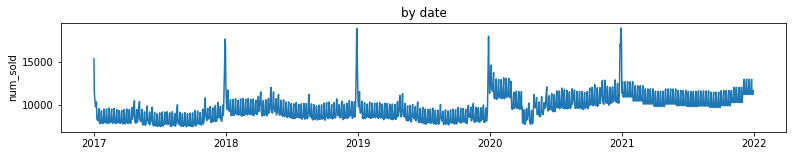

In [114]:
plt.figure(figsize=(13, 2))

concat_date = concat.groupby("date")[target].sum().reset_index()

plt.plot(concat_date["date"], concat_date[target])
plt.title("by date")
plt.ylabel(target)
plt.show()

In [115]:
s

,row_id,num_sold
0,70128,391.673012
1,70129,320.493300
2,70130,268.241914
3,70131,427.967492
4,70132,135.819004
...,...,...
17515,87643,438.282166
17516,87644,140.001849
17517,87645,112.240119
17518,87646,96.492917


In [116]:
k, b

(0, 0)

### отправка результатов

In [361]:
name = "submission.csv"
s.to_csv(name, index=False)

zout = zipfile.ZipFile(name +".zip", "w", zipfile.ZIP_DEFLATED)
zout.write(name)
zout.close()

In [362]:
!kaggle competitions submit -f submission.csv.zip -m composite_0_0 -c tabular-playground-series-sep-2022

Successfully submitted to Tabular Playground Series - Sep 2022



  0%|          | 0.00/84.5k [00:00<?, ?B/s]
  9%|9         | 8.00k/84.5k [00:00<00:02, 29.1kB/s]
100%|##########| 84.5k/84.5k [00:02<00:00, 40.1kB/s]


In [363]:
!kaggle competitions submissions -c tabular-playground-series-sep-2022

fileName              date                 description         status    publicScore  privateScore  
--------------------  -------------------  ------------------  --------  -----------  ------------  
submission.csv.zip    2022-09-09 11:17:33  mean_5_2000         complete  11.35081                   
submission.csv.zip    2022-09-09 11:07:20  mean_16_250         complete  9.91357                    
submission.csv.zip    2022-09-09 11:05:32  mean_18_500         complete  9.80350                    
submission.csv.zip    2022-09-09 11:03:26  mean_21_1000        complete  10.87576                   
submission.csv.zip    2022-09-09 11:00:36  mean_21_0           complete  10.28394                   
submission.csv.zip    2022-09-08 12:25:33  mean_18_0           complete  10.39589                   
submission.csv.zip    2022-09-08 12:23:40  mean_14_0           complete  10.81387                   
submission.csv.zip    2022-09-08 12:17:01  mean_12_0           complete  11.14692          

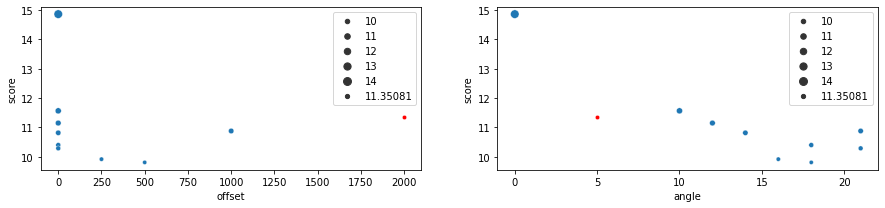

In [364]:
# noise = [1, 1, 1, 1, 1, 1, 1]

angle = [0, 10, 12, 14, 18,
         21, 21, 18, 16, 5]

offset = [0, 0, 0, 0, 0,
          0, 1000, 500, 250, 2000]

pscore = [14.86616, 11.56366, 11.14691, 10.81387, 10.39589,
          10.28394, 10.87576, 9.8035, 9.91357, 11.35081]

fig = plt.figure(figsize=(15, 3))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.scatterplot(x=offset[:-1], y=pscore[:-1], ax=ax1, size=pscore[:-1])
sns.scatterplot(x=[offset[-1]], y=[pscore[-1]], ax=ax1, color="red", size=pscore[-1])
ax1.set_xlabel("offset")
ax1.set_ylabel("score")

sns.scatterplot(x=angle[:-1], y=pscore[:-1], ax=ax2, size=pscore[:-1])
sns.scatterplot(x=[angle[-1]], y=[pscore[-1]], ax=ax2, color="red", size=pscore[-1])
ax2.set_xlabel("angle")
ax2.set_ylabel("score")

plt.show()

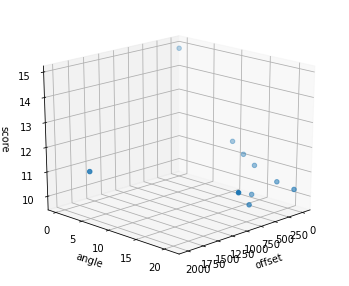

In [373]:
plt.figure(figsize=(6, 5))

axes = plt.axes(projection="3d")

axes.scatter3D(offset, angle, pscore)

axes.set_zlabel("score")
axes.set_ylabel("angle")
axes.set_xlabel("offset")
axes.view_init(20, 45)

plt.show()

### проба минимизации

In [374]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [384]:
score = []
angle = []
offset = []
noises = []

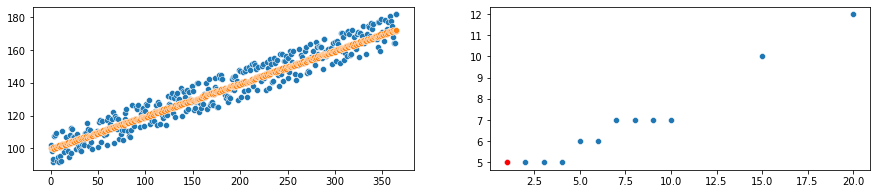

In [398]:
n = 366
k = 20
b = 100

noise = 1

x = np.linspace(0, 365, 366)
y = np.array([np.random.randint(-10, 10) + x / 5 + 100 for x in x])

a = np.array([np.random.randint(-noise, noise) + x * k / 100 + b for x in x])

error = np.sqrt(np.mean((y - a)**2))

score.append(int(error))
angle.append(k)
offset.append(b)
noises.append(noise)

fig = plt.figure(figsize=(15,3))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.scatterplot(x=x, y=y, ax=ax1)
sns.scatterplot(x=x, y=a, ax=ax1)

sns.scatterplot(x=noises[:-1], y=score[:-1], ax=ax2)
sns.scatterplot(x=[noises[-1]], y=[score[-1]], ax=ax2, color="red")

plt.show()